# 22 - Latent Dirichlet Allocation - Ejemplo Topics & Terms en Tweets Políticos


* En este Notebook vamos a agrupar los tweets publicados por los partidos políticos y los políticos para ver si verdaderamente el LDA es capaz de diferenciar las 5 tendencias políticas (5 Topics) que hay en estos tweets.


* Por otro lado tambien es interesante ver cuales son las palabras (Terms) característicos de cada uno de estos Topics.


* Para ello vamos a realizar los siguientes pasos:

    1. Carga de datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Creacción del diccionario y la bolsa de palabras
    4. Selección del número óptimo de Topics
    5. Creacción del Modelo
    6. Visualización

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import time
import pandas as pd
import numpy as np

TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Los ordenamos por fecha
df = df.sort_values(by='timestamp')

# Filtramos los tweets a partir de una fecha
DATE = "01/09/2021"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Nos quedamos solo con el nombre del partido y el tweet
tweets = [list(x) for x in df[['tweet', 'partido']].values]

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 175309
Número de Tweets a procesar: 54296


,cuenta,partido,timestamp,tweet
148444,Yolanda_Diaz_,podemos,1.639139e+09,La Inspección de Trabajo jugará un papel desta...
167093,Pam_Angela_,podemos,1.645738e+09,"@Calle51 Ay, Javi❤️."
128275,CiudadanosCs,ciudadanos,1.632731e+09,Cs lleva años defendiendo la presencia de la P...
138605,PSOE,psoe,1.635967e+09,Unas cuentas que miran especialmente a nuestro...
174313,Macarena_Olona,vox,1.648488e+09,https://t.co/DIv2Dftb74
163130,IdoiaVR,podemos,1.644329e+09,Los humedales en España piden auxilio.@SEO_Bir...
131991,PODEMOS,podemos,1.633858e+09,"""Hemos alcanzado un acuerdo histórico, una Ley..."
130181,Jorgebuxade,vox,1.633288e+09,"Mientras, Casado, Rajoy, Soraya, y el gobierno..."
171214,IreneMontero,podemos,1.647234e+09,@petrogustavo Enhorabuena querido compañero. S...
152759,oscar_puente_,psoe,1.640791e+09,@Kolvjose Tienes buena memoria. 😉


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

#### CUIDADO - IMPORTANTE:

* Dado que los procesos de normalización de textos son muy pesados y tardan mucho, se ha implementado despues de la normalización de los tweets, un proceso de guardado de los tweets ya normalizados. Por tanto:
    - Si es la primera vez que se ejecuta este notebook, se puede ejecutar completo sabiendo que se guardarán en un fichero binario los tweets normalizados. Este guardado se realiza [AQUI](#Escritura).
    - En caso de haberse ejecutado el proceso de normalización de tweets y haberse guardado este en un fichero binario, no será necesario ejecutar las dos siguientes celdas de código y bastaría con ejecutar la celda de código que lee el fichero binario con los tweets normalizados. Esto se hace en la siguiente [CELDA](#Lectura).

In [2]:
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

def normalize(tweets, min_words=3):
    """
    Función que dada una lista de tweets, normaliza los tweets y devuelve una lista con los tweets normalizados, 
    descartando aquellos tweets que tras la normalización tengan menos de "min_words" palabras en el tweet.
    
    :param tweets:       Lista de Tweets con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets normalizados
    """
    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append(tw)
    return tweets_list

# Normalizamos las frases
X_norm = normalize(tweets)

100%|███████████████████████████████████████████████████████████████████████████| 54296/54296 [05:54<00:00, 153.33it/s]


#### <a name="Escritura">Guardado de los tweets normalizados en un fichero binario</a>

* Se guarda una lista de listas, donde en cada una de las listas se tiene:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [3]:
import pickle

filename = './models/22_normalized_tweets_lda.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm, save_list)
save_list.close()


#### <a name="Lectura">Lectura de los tweets normalizados de un fichero binario</a>

* Lectura de una lista con la siguiente estructura:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [2]:
import pickle

filename = './models/22_normalized_tweets_lda.pickle'
X_norm = pickle.load(open(filename, 'rb'))


<hr>


## Creamos el Diccionario y la Matriz (Bolsa de Palabras)

In [3]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in X_norm:
    for token in doc:
        frequency[token] += 1

documents = [[token for token in doc] for doc in X_norm]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary(93742 unique tokens: ['aplaudar', 'arce', 'añez', 'cartel', 'celebrar']...)

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


<hr>


## Selección del número óptimo de Topics


* Veamos la coherencia para modelos desde 2 a 10 temas (Topics).

In [4]:
warnings.filterwarnings('ignore')
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence = []
min_topics = 2
max_topics = 11
for num_topics in tqdm(range(min_topics, max_topics, 1)):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=0,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=X_norm, dictionary=dictionary, coherence='u_mass')
    coherence.append(coherencemodel.get_coherence())
    
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [49:02<00:00, 326.97s/it]


,Coherence
Num Topics: 2,-3.451169
Num Topics: 3,-3.462394
Num Topics: 4,-4.299516
Num Topics: 5,-4.670367
Num Topics: 6,-4.703064
Num Topics: 7,-4.391761
Num Topics: 8,-5.492492
Num Topics: 9,-5.323364
Num Topics: 10,-5.475748


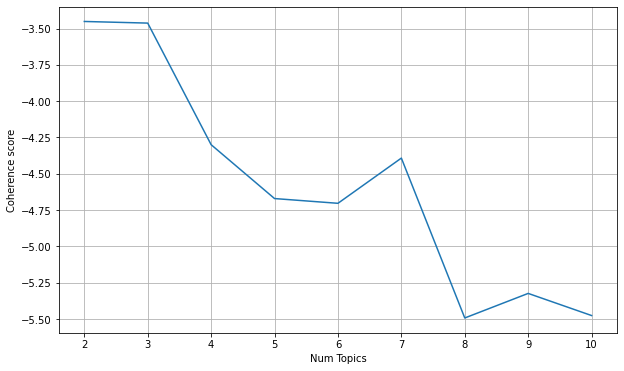

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creamos el Modelo:


* Con la coherencia obtenida, podemos observar que ***4 y 7 Topics*** serie un buen número de temas a seleccionar, aunque "lo esperado" hubiese sido tener 5 Topics correspondientes a 5 tendencias políticas.


* Vamos a crear el modelo con 5 Topics para ver si vemos diferencias entre las 5 tendencias políticas:

In [6]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=0)

<hr>


## Visualización 5 Topics:

In [7]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

<hr>


## Nube de etiquetas por Tópico


* Utilizando el último modelo generado del LDA, vamos a asignar el tópico al que pertenece cada documento y vamos a generar una nube de palabras por tópico.


* Para ello vamos a obtener el tópico más problable dado un documento, obteniendo las probabilidades de pertenencia al tópico dado por la función "*get_document_topics()*".


* Una vez asignado el tópico al documento creamos la nube de palabras (etiquetas).

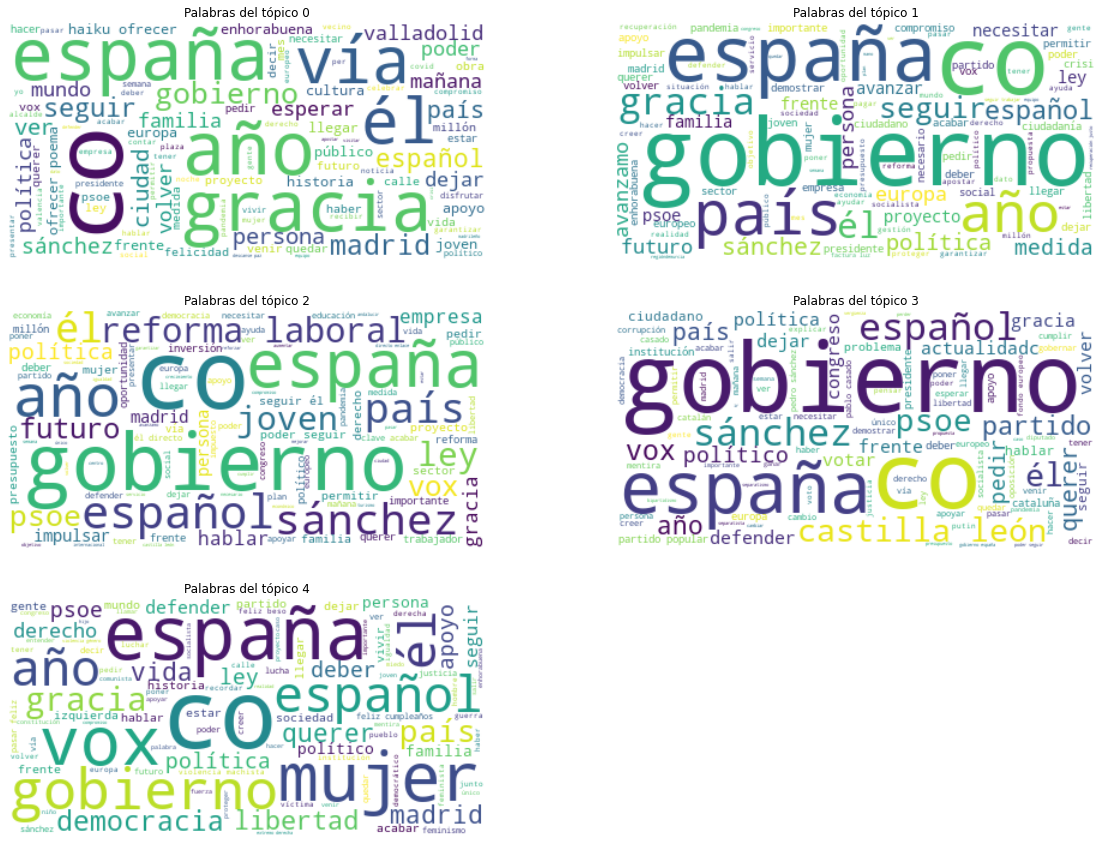

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Obtenemos el tópico más probable para cada documento del corpus
document_topics = [[tup[1] for tup in lst].index(max([tup[1] for tup in lst])) for lst in lda_model[corpus]]


# Procesamiento y pintado de las nubes de etiquetas
plt.figure(figsize=(20, 15))
pos = 1
for topic in set(document_topics):   
    # Obtenemos las palabras por tópico
    words = ' '.join([' '.join(X_norm[i]) for i, x in enumerate(document_topics) if x == topic])
    
    # Pintamos las 5 nubes de etiquetas
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras del tópico {}".format(topic))
    pos += 1
plt.show()